In [1]:
# %load imports.ipy
# Stdlib
%matplotlib inline

from swozny_ml import *
# jt --cellwidth 100% --vimext  -t monokai -f roboto
jtplot.style('monokai')
pd.set_option('display.max_columns',102)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.width',120)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 
custom_style = {'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white', };
sns.set_style( rc=custom_style)
mpl.rcParams['figure.figsize']=(10,10);plt.rcParams['figure.figsize']=(10,10);
from sklearn.metrics import make_scorer

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

'numpy 1.13.3 pandas 0.20.3 sklearn 0.19.1'


/home/swozny/untitled5/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
filename = 'datasets/houses.csv'
index = 'Id'
target = 'SalePrice'
scoring = make_scorer(neg_log_mean_squared_error_inv_boxcox,greater_is_better=True)

In [3]:
# Read data
data = pd.concat([pd.read_csv(filename, index_col=index),
                  pd.read_csv('datasets/houses_test.csv', index_col=index)])
data = data.drop(data[(data['GrLivArea'] > 4000) &
                      (data['SalePrice'] < 300000)].index)
data = data.drop(['Utilities'], axis=1)
X = ['Alley', 'MasVnrArea', 'BsmtCond', 'FireplaceQu', 'GarageCond', 'GarageArea', 'GarageCars',
     'GarageQual', 'GarageFinish', 'GarageType', 'PoolQC', 'MiscFeature', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtUnfSF', 'Fence']
for col in X:
    data[col] = data[col].fillna(0)
    
data['MasVnrType']=data['MasVnrType'].fillna('None')
data['GarageYrBlt']=data[ 'GarageYrBlt'].fillna(1900)
data['Functional']=data['Functional'].fillna('Typ')
data['BsmtFinType1']=data['BsmtFinType1'].fillna('Unf')
data['BsmtFinType2']=data['BsmtFinType2'].fillna('Unf')
data['Exterior1st']=data['Exterior1st'].fillna('Other')
data['Exterior2nd']=data['Exterior2nd'].fillna('Other')
data['Electrical']=data['Exterior2nd'].fillna('SBrkr')
data['MSSubClass'] = data['MSSubClass'].fillna("None")
data['KitchenQual'] = data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])
data['TotalBsmtSF'] = data['BsmtFinSF1'] + data['BsmtFinSF2'] +  data['BsmtUnfSF']
data['total_sf'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

deskew = [target,'LotArea','GrLivArea','LowQualFinSF','LotFrontage','MiscVal',
          'PoolArea','3SsnPorch','EnclosedPorch','ScreenPorch','MasVnrArea','WoodDeckSF',
         'total_sf','TotalBsmtSF','1stFlrSF','GarageYrBlt','LowQualFinSF','2ndFlrSF']
for col in data.select_dtypes(include=[np.number]):
    data[col]=boxcox(data[col])

Reduced skew from 1.2573 to -0.0001 for 1stFlrSF
Reduced skew from 0.8616 to 0.2969 for 2ndFlrSF
Reduced skew from 11.3721 to 8.7092 for 3SsnPorch
Reduced skew from 0.3266 to 0.0932 for BedroomAbvGr
Reduced skew from 0.9806 to -0.4037 for BsmtFinSF1
Reduced skew from 4.1445 to 2.3541 for BsmtFinSF2
Reduced skew from 0.6224 to 0.3574 for BsmtFullBath
Reduced skew from 3.9300 to 3.7057 for BsmtHalfBath
Reduced skew from 0.9197 to -0.2766 for BsmtUnfSF
Reduced skew from 4.0023 to 1.8820 for EnclosedPorch
Reduced skew from 0.7253 to 0.1128 for Fireplaces
Reduced skew from 0.1655 to -0.0301 for FullBath
Failed to reduce skew with BoxCox for GarageArea
Reduced skew from -0.2193 to -0.0085 for GarageCars
Reduced skew from -0.7024 to 0.2681 for GarageYrBlt
Reduced skew from 1.0688 to 0.0002 for GrLivArea
Reduced skew from 0.6967 to 0.5358 for HalfBath
Reduced skew from 4.3006 to -2.0625 for KitchenAbvGr
Reduced skew from 13.1095 to 0.1107 for LotArea
Reduced skew from 1.1213 to 0.1095 for LotF

/home/swozny/untitled5/lib/python3.6/site-packages/scipy/stats/morestats.py:901: RuntimeWarning: overflow encountered in square
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/home/swozny/untitled5/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/swozny/untitled5/lib/python3.6/site-packages/scipy/stats/stats.py:952: RuntimeWarning: overflow encountered in multiply
  s *= a_zero_mean
/home/swozny/untitled5/lib/python3.6/site-packages/scipy/stats/stats.py:1060: RuntimeWarning: overflow encountered in power
  lambda m2, m3: m3 / m2**1.5,


In [4]:
dontknow = ['PoolArea','MiscVal']
qcuts = ['BsmtUnfSF','2ndFFlrSF','BsmtFinSF1','BsmtFinSF2','MasVnrArea','WoodDeckSF']
categorical=['KitchenAbvGr','OverallCond']

Predicting LotFrontage and it is a regression problem
Evaluating LGBMRegressor...-5.09 -3.81 -11.34 -6.27 -3.84 -4.13 ... best is (-3.8069662753781741, 0.19110940143142424, LGBMRegressor(boosting_type='gbdt', colsample_bytree=0.74515020093660744,
       learning_rate=0.15477506171343897, max_bin=255, max_depth=-1,
       min_child_samples=10, min_child_weight=3, min_split_gain=0.0,
       n_estimators=24, n_jobs=-1, num_leaves=100, objective=None,
       random_state=0, reg_alpha=1.0165221760502872,
       reg_lambda=1.4464050556671946, silent=True,
       subsample=0.72605537653770136, subsample_for_bin=50000,
       subsample_freq=1)).
Evaluating AdaBoostRegressor...-6.28 -5.44 -5.70 -5.75 -5.59 -5.77 ... best is (-5.4438682031205472, 0.37352796944398819, AdaBoostRegressor(base_estimator=None, learning_rate=0.045491506978836471,
         loss='linear', n_estimators=100, random_state=None)).
Evaluating GradientBoostingRegressor...-3.91 failed failed failed failed failed ... best is (-

TypeError: '>' not supported between instances of 'RandomForestRegressor' and 'RandomForestRegressor'

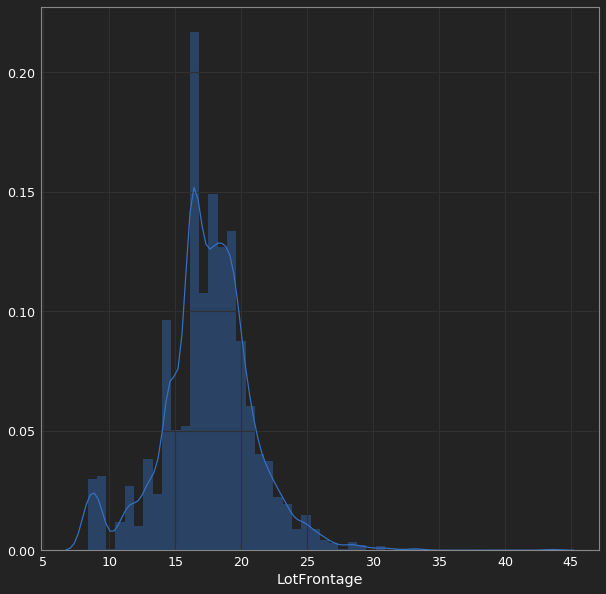

In [5]:
data=impute_linear(data,'LotFrontage',['LotArea','GarageArea','GrLivArea','MiscVal'],['Neighborhood','MSSubClass','LotShape','BldgType','LotConfig','Foundation','GarageType'],'neg_mean_squared_error')
data=impute_logistic(data,'SaleType',['YearBuilt'],['Neighborhood','MSSubClass','RoofStyle','RoofMatl','SaleCondition','ExterCond','BldgType','MasVnrType','OverallQual','OverallCond','MSZoning'],'accuracy')

In [ ]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual',
         'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    data[c] = lbl.fit_transform(list(data[c].values))
data=merge_categorical(data,['Condition1','Condition2'])
data=merge_categorical(data,['Exterior1st','Exterior2nd'])
data=merge_categorical(data,['BsmtFinType2','BsmtFinType1'])
data=pd.get_dummies(data)

In [ ]:
from sklearn.preprocessing import StandardScaler,RobustScaler
_data = data.drop(target,axis=1)
_data[_data.columns]=StandardScaler().fit_transform(X=data.drop(target,axis=1))
from sklearn.decomposition import PCA
p=PCA()
p.fit(_data)
__data=p.transform(_data)
___data=pd.DataFrame(__data,index=data.index)
___data[target]=data[target]
# _data[_data.columns]=__data
# _data[target]=data[target]
___data.to_csv('datasets/houses_preprocessed.csv')
# data.to_csv('datasets/houses_preprocessed.csv')
# data

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
data_p = pd.read_csv('datasets/houses_preprocessed.csv', index_col='Id')
data_p=shuffle(data_p)
cond = data_p[target].notnull()
X, y = data_p.drop(target, axis=1),data_p[target]

X=RobustScaler().fit_transform(X=X)
# X=PCA().fit_transform(X)
X_train, y_train = X[cond], y[cond]
X_test, y_test = X[~cond], y[~cond]

results  = benchmark_models([make_pipeline(ElasticNet(alpha=0.0001)),Lasso(alpha=0.0008),BayesianRidge(),LassoLarsIC(),KernelRidge(),],X_train,y_train,scoring=scoring)
# results  = benchmark_models([make_pipeline(RobustScaler(),ElasticNet(alpha=0.00008, l1_ratio=.5, ))],X_train,y_train,scoring=scoring)
# results  = benchmark_models([GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
#                                    max_depth=4, max_features='sqrt',
#                                    min_samples_leaf=15, min_samples_split=10, 
#                                    loss='huber',)],X_train,y_train,scoring=scoring)
# plot_benchmark(results)
# # best_models = tune_params_genetic([LGBMRegressor,XGBRegressor], X_train, y_train, scoring)
# best_models = tune_params_genetic([BayesianRidge], X_train, y_train, scoring)

# m = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
# m=GradientBoostingRegressor(n_estimators=1000,learning_rate=0.05)
# m =XGBRegressor()
m=BayesianRidge()
print(-cross_val_score(m, X_train, y_train, scoring=scoring,cv=3).mean())

m.fit(X_train, y_train)

In [ ]:
X_test = data_p[~cond].drop(target, axis=1)
X_test[target] = m.predict(X_test)
X_test['SalePrice'] = inv_boxcox(X_test[target])
# X_test['SalePrice'] = np.exp(X_test[target])
pred = X_test.SalePrice
pred.to_csv('predictions/houses.csv', header=True)

In [ ]:
from sklearn.metrics import make_scorer
print(cross_val_score(m, X_train, y_train, scoring=scoring,cv=3,n_jobs=-1))

In [ ]:
X_train